* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [13]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite 
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt
from cobra.flux_analysis.loopless import loopless_solution


In [14]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1]


In [15]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1]
    growth_rates = [0.03396, 0.082468, 0.123068, 0.17302, 0.233464]
    
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective =  "ATPM"# 
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.reactions.BIOMASS_RT.bounds = growth_rates[i], growth_rates[i]
    model.optimize('minimize')
    solution = loopless_solution(model) 
    
    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])

    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])
    

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

In [16]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, **fig_kw):
    threshold = 0.05# threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880_jsb.xml")
    model.objective = "ATPM" 
    solution = model.optimize('minimize')   
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    fig = plt.figure(**fig_kw)
           
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    # plt.title(title)

    
    return pie_chart, fig

In [17]:
# import pickle

# with open("../cofactor_comparison/IFO0880_jsb_NGAM_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)


In [18]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate
nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

SUM produced: 0.572165347439996, SUM consumed: -0.572165347439996
SUM produced: 3.933451433295837, SUM consumed: -3.933451433295837


,flux,reaction,percent
ALDD19x_P,2.934494,ALDD19x_P,0.746035
G6PDH2r,0.302394,G6PDH2r,0.076877
GND,0.302394,GND,0.076877
ALDD2ym,0.214555,ALDD2ym,0.054546
PYDXOR,0.164883,PYDXOR,0.041918
PPND2,0.014732,PPND2,0.003745
3NPHBH2_m,-0.000173,3NPHBH2_m,0.000044
COQ7_m,-0.000173,COQ7_m,0.000044
DPR,-0.000180,DPR,0.000046
HEMEASm,-0.000323,HEMEASm,0.000082


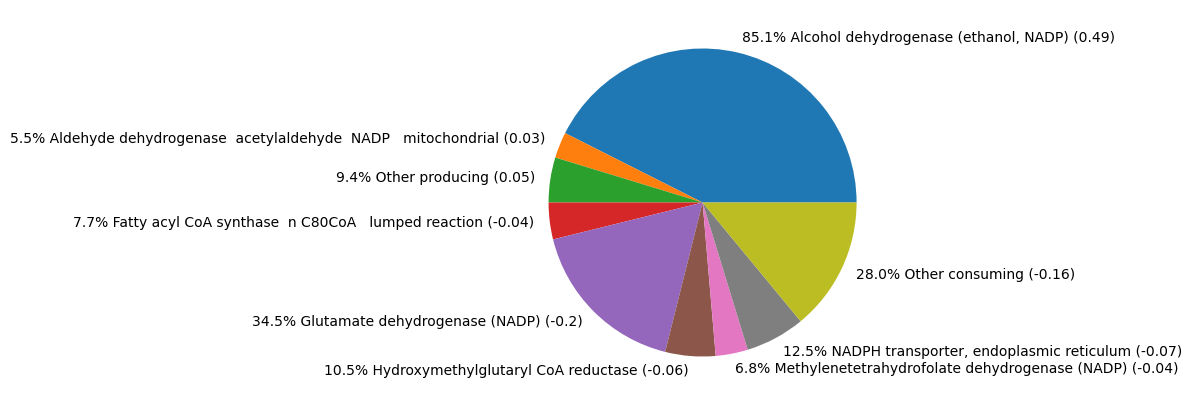

In [19]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, figsize=(13,5))
producing_nadph_fluxes_lowest_GR_pie_chart

plt.show()
fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\Rt_IFO0880_LEBp2023_nm_NADPH.png")


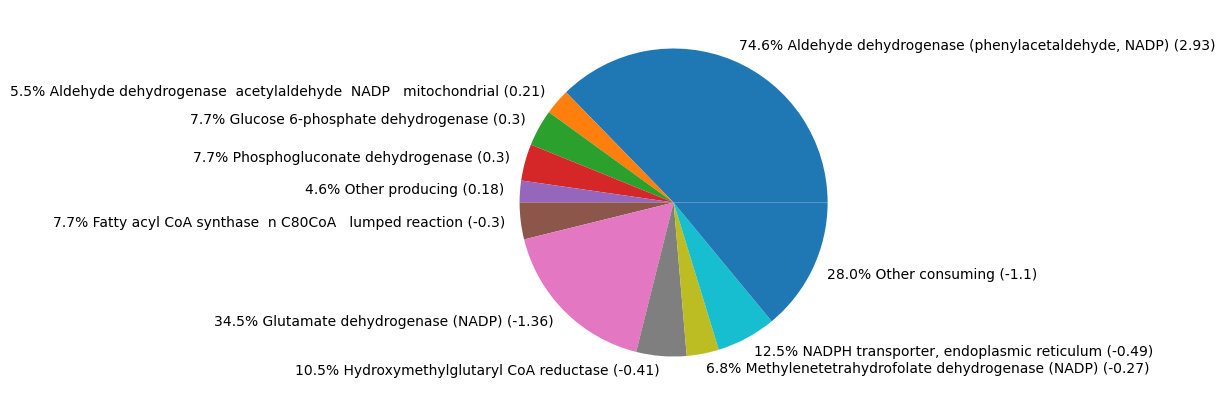

In [20]:
# Make a pie plot for napdh
# threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title, figsize=(13,5))
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\Rt_IFO0880_LEBp2023_nm_NADPH_max.png")


In [21]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 1)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

SUM produced: 5.4278226214402165, SUM consumed: -5.4278226214402165
SUM produced: 14.72163782912129, SUM consumed: -14.72163782912129


,flux,reaction,percent
GAPD,4.345425,GAPD,2.951727e-01
MDHm,3.350731,MDHm,2.276058e-01
PDHm,3.259048,PDHm,2.213781e-01
ICDHxm,1.785725,ICDHxm,1.212994e-01
AKGDm,1.509423,AKGDm,1.025309e-01
HICITDm,0.106934,HICITDm,7.263760e-03
IPMD,0.074756,IPMD,5.077991e-03
HACD1m,0.066701,HACD1m,4.530791e-03
2OXOADOXm,0.066701,2OXOADOXm,4.530791e-03
SACCD2,0.040234,SACCD2,2.732969e-03


([<matplotlib.patches.Wedge at 0x1dd79102c90>,
 [Text(1.0846096455720144, 0.18336280084070794, '10.7% 2-oxoglutarate dehydrogenase (0.58)'),
  Text(0.7724009646509286, 0.7831964950166178, '29.1% Glyceraldehyde-3-phosphate dehydrogenase (1.58)'),
  Text(0.13752496829246322, 1.091369269814831, '12.5% Isocitrate dehydrogenase  NAD (0.68)'),
  Text(-0.4546286894142247, 1.001655007855252, '22.6% Malate dehydrogenase  mitochondrial (1.23)'),
  Text(-0.8116913353240077, 0.7423996067886415, '3.1% Other producing (0.17)'),
  Text(-1.0346866353211495, 0.37339465273059114, '22.0% Pyruvate dehydrogenase (1.2)'),
  Text(-1.046503330057091, -0.3388669062912744, '19.9% Alcohol dehydrogenase (ethanol) (-1.08)'),
  Text(-0.7929003018266929, -0.7624362998724151, '8.9% malate dehydrogenase (-0.48)'),
  Text(0.4531810288162035, -1.0023108076445586, '69.4% NADH dehydrogenase, mitochondrial (-3.77)'),
  Text(1.0995678776688005, -0.030829894565664363, '1.8% Other consuming (-0.1)')])

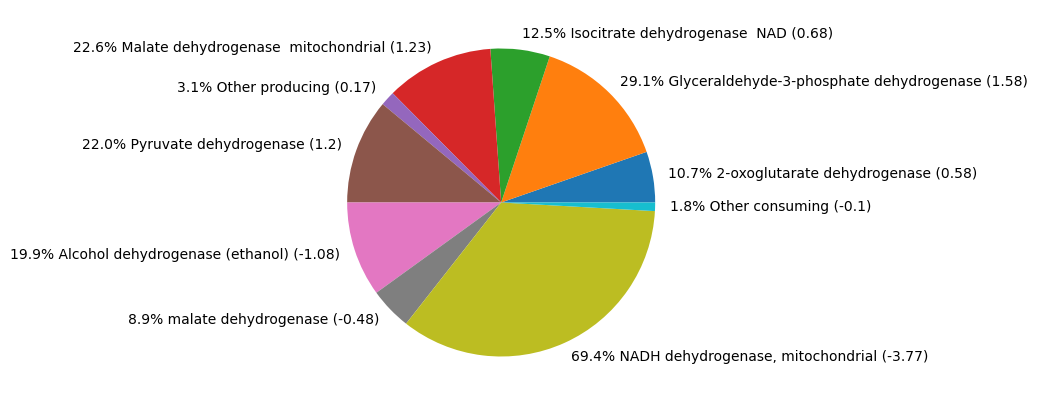

In [22]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, figsize=(13,5))
producing_nadh_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1dd7cae67e0>,
 [Text(1.0857644870017369, 0.17639580144055436, '10.3% 2-oxoglutarate dehydrogenase (1.51)'),
  Text(0.7775308784380991, 0.7781039346226687, '29.5% Glyceraldehyde-3-phosphate dehydrogenase (4.35)'),
  Text(0.14351045387833306, 1.0905983447757635, '12.1% Isocitrate dehydrogenase  NAD (1.79)'),
  Text(-0.4457445431335916, 1.0056399963538771, '22.8% Malate dehydrogenase  mitochondrial (3.35)'),
  Text(-0.8080253026517452, 0.7463880426926438, '3.2% Other producing (0.47)'),
  Text(-1.0341598438369635, 0.37485119366904446, '22.1% Pyruvate dehydrogenase (3.26)'),
  Text(-1.0465182149636376, -0.3388209346385223, '19.9% Aldehyde dehydrogenase (phenylacetaldehyde, NAD) (-2.93)'),
  Text(-0.7882976611787134, -0.7671941067162668, '9.3% malate dehydrogenase (-1.36)'),
  Text(0.4580219879005575, -1.0001079234760726, '68.9% NADH dehydrogenase, mitochondrial (-10.15)'),
  Text(1.0995292283946911, -0.032178811441307, '1.9% Other consuming (-0.27)')])

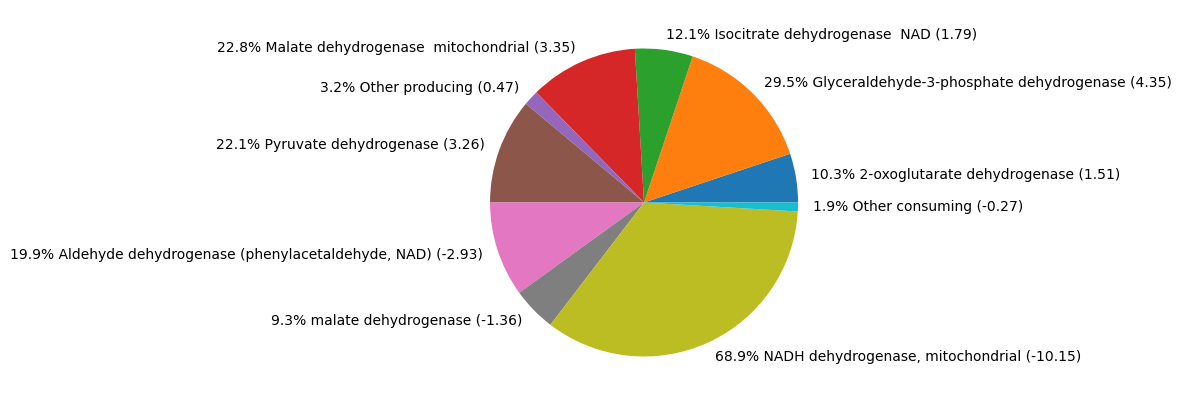

In [23]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, figsize=(13,5))
producing_nadh_fluxes_highest_GR_pie_chart

In [24]:
# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

SUM produced: 7.966362592016365, SUM consumed: -7.966362592016366
SUM produced: 47.18294641279054, SUM consumed: -47.18294641279059


,flux,reaction,percent
ATPS3m,37.069770,ATPS3m,0.785660
PGK,4.345425,PGK,0.092097
PYK,4.258030,PYK,0.090245
SUCOASm,1.508132,SUCOASm,0.031964
URIDK2r,0.001589,URIDK2r,0.000034
...,...,...,...
ACITL,-1.253723,ACITL,0.026572
ADK1,-1.495730,ADK1,0.031701
PFK,-2.140033,PFK,0.045356
HEX1,-3.100000,HEX1,0.065702


([<matplotlib.patches.Wedge at 0x1dd72069280>,
 [Text(0.3519233687838743, 1.0421851766858947, '79.3% ATP synthase  mitochondrial (6.31)'),
  Text(-0.9102558162628128, 0.61760371514404, '3.5% Other producing (0.28)'),
  Text(-1.011236750809771, 0.4328974864927, '8.7% Phosphoglycerate kinase (0.69)'),
  Text(-1.0901401439431995, 0.14695055822793074, '8.5% Pyruvate kinase (0.68)'),
  Text(-1.0683052739351626, -0.2621523253421904, '15.3% ATP maintenance requirement (-1.22)'),
  Text(-0.16888655584089785, -1.0869578332466259, '59.5% Biomass (-4.74)'),
  Text(0.8443652507052857, -0.7050158320218066, '6.0% Hexokinase (D-glucose:ATP) (-0.48)'),
  Text(1.0505700195902081, -0.3260408470394925, '19.2% Other consuming (-1.53)')])

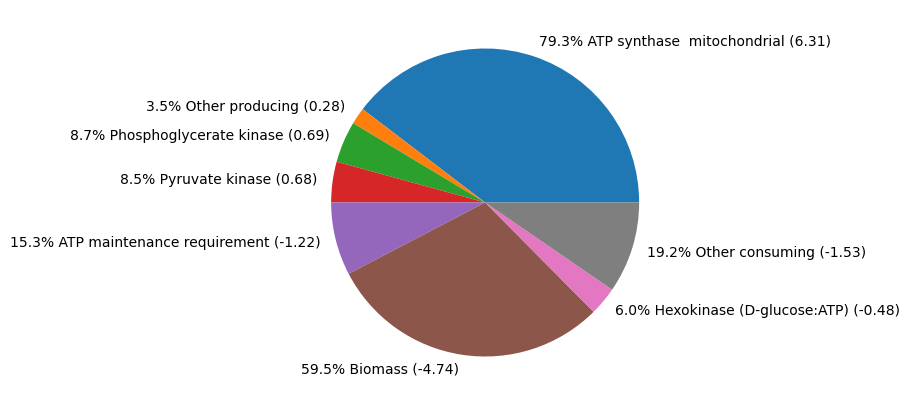

In [25]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title, figsize=(13,5))
producing_atp_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1dd04c4f980>,
 [Text(0.3633949696778166, 1.0382408660868916, '78.6% ATP synthase  mitochondrial (37.07)'),
  Text(-0.8932762632519556, 0.6419170643553754, '3.2% Other producing (1.51)'),
  Text(-1.0006954331136717, 0.4567369594694971, '9.2% Phosphoglycerate kinase (4.35)'),
  Text(-1.0889662676497316, 0.1554106428820532, '9.0% Pyruvate kinase (4.26)'),
  Text(-0.512907916546769, -0.9731009552680816, '69.1% Biomass (-32.61)'),
  Text(0.7118636905054809, -0.8386000752086283, '6.6% Hexokinase (D-glucose:ATP) (-3.1)'),
  Text(1.0207634946256137, -0.409929125629913, '24.3% Other consuming (-11.47)')])

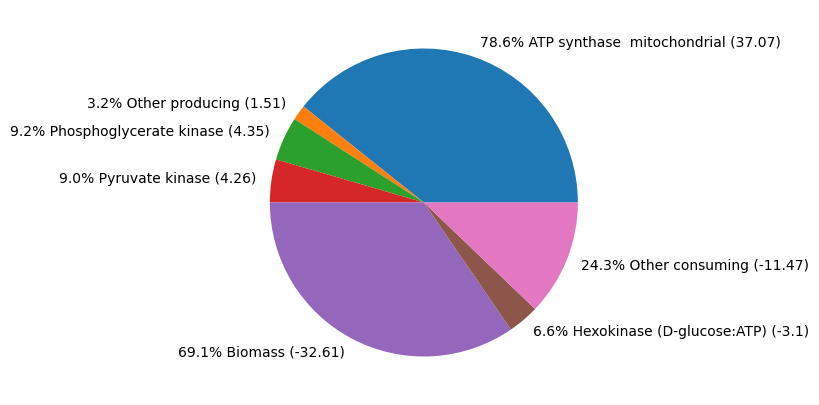

In [26]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'Rt_IFO0880_LEBp2023 ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  figsize=(13,5))
producing_atp_fluxes_highest_GR_pie_chart

In [27]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_jsb_results\\Rt_IFO0880_jsb_all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_lowest, 2)}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {round(biomass_GR_highest, 2)}', index=False)
